<a href="https://colab.research.google.com/github/gDan15/AI_colab/blob/master/Model_elaboration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Check and install tensorflow

In [0]:
# To determine which version you're using:
!pip show tensorflow

Name: tensorflow
Version: 1.14.0rc0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.6/dist-packages
Requires: six, tensorboard, keras-preprocessing, gast, absl-py, astor, wheel, wrapt, google-pasta, tf-estimator-nightly, numpy, protobuf, grpcio, termcolor, keras-applications
Required-by: stable-baselines, magenta, fancyimpute


In [0]:
# For the current version: 
# !pip install --upgrade tensorflow

# For installing previous version
 !pip install tensorflow==1.14.0rc0

# For the latest nightly build:
# !pip install tf-nightly

In [0]:
!pip install Pillow

## Load files

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
pwd

'/content/gdrive/My Drive/Colab Notebooks'

In [0]:
cd /content/gdrive/My\ Drive/Colab Notebooks/

/content/gdrive/My Drive/Colab Notebooks


In [0]:
ls

 AI.ipynb       drive.ipynb       IMG/
 checkpoints/   driving_log.csv  'Model elaboration'


## Packages

In [0]:
import csv, random, numpy as np
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.preprocessing.image import img_to_array, load_img, random_shift
from tensorflow.keras.models import load_model, Sequential
from PIL.Image import Image

# from tensorflow.keras.models import load_model, Sequential
# from tensorflow.keras.layers import Dense, Dropout, Flatten
# from tensorflow.keras.layers.convolutional import Convolution2D, MaxPooling2D
# from tensorflow.keras.preprocessing.image import img_to_array, load_img, flip_axis, random_shift

## Model

In [0]:
def model(load, shape, checkpoint=None):
  if load and checkpoint: return load_model(checkpoint)
  conv_layers, dense_layers = [32, 32, 64, 128], [1024, 512]
  model = tf.keras.models.Sequential()
  model.add(layers.Conv2D(32, (3, 3), strides=1, activation='elu', input_shape=shape))
  model.add(layers.MaxPooling2D())
  for cl in conv_layers:
      model.add(layers.Conv2D(filters=cl, kernel_size=(3, 3), strides=1, activation='elu'))
      model.add(layers.MaxPooling2D())
  model.add(layers.Flatten())
  for dl in dense_layers:
      model.add(layers.Dense(dl, activation='elu'))
      model.add(layers.Dropout(0.5))
  model.add(layers.Dense(1, activation='linear'))
  model.compile(loss='mse', optimizer="adam")
  return model

### Testing model

In [0]:
net = model(load=False, shape=(100, 100, 3))

## Process data

In [0]:
def get_X_y(data_file):
    """Read the log file and turn it into X/y pairs. Add an offset to left images, remove from right images."""
    X, y = [], []
    steering_offset = 0.4
    with open(data_file) as fin:
        for center_img, left_img, right_img, steering_angle, _, _, speed in csv.reader(fin):
            if float(speed) < 20: continue  # throw away low-speed samples
#            left_img = left_img.strip()
#            left_img = "/content/gdrive/My Drive/Colab Notebooks/IMG/" + left_img.split("/")[-1]
#            right_img = left_img.strip()
#            right_img = "/content/gdrive/My Drive/Colab Notebooks/IMG/" + right_img.split("/")[-1]
            center_img = center_img.strip()
            center_img = "/content/gdrive/My Drive/Colab Notebooks/IMG/" + center_img.split("/")[-1]
#            X += [left_img, right_img]
            X += [center_img]
            y += [float(steering_angle) + steering_offset, float(steering_angle) - steering_offset]
    return X, y

In [0]:
# X, y = get_X_y('/content/gdrive/My Drive/Colab Notebooks/driving_log/driving_log_16_06.csv')
# print(X)
# print(y)

## Process image

In [0]:
def random_darken(image):
    """Given an image (from Image.open), randomly darken a part of it."""
    #grace_hopper = tf.keras.utils.get_file(image_path)
    
    w, h = image.size

    # Make a random box.
    x1, y1 = random.randint(0, w), random.randint(0, h)
    x2, y2 = random.randint(x1, w), random.randint(y1, h)

    # Loop through every pixel of our box (*GASP*) and darken.
    for i in range(x1, x2):
        for j in range(y1, y2):
            new_value = tuple([int(x * 0.5) for x in image.getpixel((i, j))])
            image.putpixel((i, j), new_value)
    return image

In [0]:
def process_image(path, steering_angle, augment, shape=(100,100)):
    """Process and augment an image."""
    image = load_img(path, target_size=shape)
    
#     if augment and random.random() < 0.5:
#         image = random_darken(image)  # before numpy'd

    image = img_to_array(image)
        
    if augment:
        image = random_shift(image, 0, 0.2, 0, 1, 2)  # only vertical
        if random.random() < 0.5:
#             image = apply_transform(image, "flip_horizontal")
            steering_angle = -steering_angle

    image = (image / 255. - .5).astype(np.float32)
    return image, steering_angle

### Test random_darken

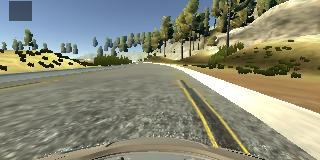

In [0]:
image = Image.open("IMG/center_2019_03_29_14_20_37_224.jpg")
random_darken(image)

## Train model

In [0]:
def _generator(batch_size, X, y):
    """Generate batches of training data forever."""
    while 1:
        batch_X, batch_y = [], []
        for i in range(batch_size):
            sample_index = random.randint(0, len(X) - 1)
            sa = y[sample_index]
#             try:
            image, sa = process_image(X[sample_index], sa, augment=True)
            batch_X.append(image)
            batch_y.append(sa)
#             except FileNotFoundError:
#               next
        yield np.array(batch_X), np.array(batch_y)


In [0]:
def train():
    """Load our network and our data, fit the model, save it."""
    net = model(load=False, shape=(100, 100, 3))
    X, y = get_X_y('/content/gdrive/My Drive/Colab Notebooks/driving_log/driving_log.csv')
    net.fit_generator(_generator(256, X, y), steps_per_epoch=100, epochs=2)
    net.save('checkpoints/short_random_darken_added.h8')

In [0]:
def load(checkpoint):
  return load_model(checkpoint)

In [136]:
cd /content/gdrive/My\ Drive/Colab Notebooks/

/content/gdrive/My Drive/Colab Notebooks


In [139]:
if __name__ == '__main__':
  train()
#     net = .load('checkpoints/short_doesnt_work.h5')
#     print(net)

FileNotFoundError: ignored